In [4]:
# Include sslearn folder
import sys
sys.path.append('../../../sslearn')
from sslearn.wrapper import CoTraining
from sslearn.base import OneVsRestSSLClassifier
import pickle as pkl
import numpy as np
import os
from SequenceEncoding import SequenceEncoding
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, weightedtau
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations, permutations

# Results files reading and preprocessing

In [6]:
avgfp_results_dirs = [(2, "Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_2_avgfp_Ridge"),
                      (3, "Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_3_avgfp_Ridge"),
                      (4, "Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_4_avgfp_Ridge"),
                      (5, "Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_5_avgfp_Ridge"),
                      (6, "Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_6_avgfp_Ridge"),
                      (7, "Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_7_avgfp_Ridge"),
                      (8, "Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_8_avgfp_Ridge"),
                      (9, "Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_9_avgfp_Ridge"),
                      (10, "Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_10_avgfp_Ridge"),(2, "StandardScaler_Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_2_avgfp_StandardScaler_Ridge"),
                      (3, "StandardScaler_Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_3_avgfp_StandardScaler_Ridge"),
                      (4, "StandardScaler_Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_4_avgfp_StandardScaler_Ridge"),
                      (5, "StandardScaler_Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_5_avgfp_StandardScaler_Ridge"),
                      (6, "StandardScaler_Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_6_avgfp_StandardScaler_Ridge"),
                      (7, "StandardScaler_Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_7_avgfp_StandardScaler_Ridge"),
                      (8, "StandardScaler_Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_8_avgfp_StandardScaler_Ridge"),
                      (9, "StandardScaler_Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_9_avgfp_StandardScaler_Ridge"),
                      (10, "StandardScaler_Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_10_avgfp_StandardScaler_Ridge")]
pabp_yeast_results_dirs = [
                        (2, "Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_2_PABP_YEAST_Fields2013_Ridge"),
                        (2, "StandardScaler_Ridge", "results/masking_generalization_experiments_AFTERMASK_TEST/masking_experiments_trainedwith_1_testedwith_2_PABP_YEAST_Fields2013_StandardScaler_Ridge")]

results_dirs_dict = {"avgfp": avgfp_results_dirs, "PABP_YEAST_Fields2013": pabp_yeast_results_dirs}

In [7]:
encodings = ["One_hot", "One_hot_6_bit", "Binary_5_bit", "Hydrophobicity_matrix",
             "Meiler_parameters", "Acthely_factors", "PAM250", "BLOSUM62",
             "Miyazawa_energies", "Micheletti_potentials", "AESNN3",
             "ANN4D", 
             #"ProtVec"
             ]
global_masks = ["relative",
                "relativex2",
                "relativex10",
                "relativex0.5",
                "relativex0.1",
                "shannon",
                "shannonx2",
                "shannonx10",
                "shannonx0.5",
                "shannonx0.1",
                "lockless",
                "locklessx2",
                "locklessx10",
                "locklessx0.5",
                "locklessx0.1",
                "1-shannon",
                "inverted_relative",
                "inverted_shannon",
                "inverted_lockless",
                "normalized_relative",
                "normalized_shannon",
                "normalized_lockless",
                "random"]
individual_masks = []
after_masks = [ "after_0.1",
                "after_0.25",
                "after_0.5",
                "after_0.75",
                "after_1",
                "after_1.5",
                "after_2",
                "after_5",
                "after_10"]
masks = global_masks + individual_masks
labeled_sizes_list = [1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.03, 0.01]

In [8]:
global_pred_dict = dict()

for dataset, results_dirs in results_dirs_dict.items():
    global_pred_dict[dataset] = dict()
    for variant_num, model, results_dir in results_dirs:
        global_pred_dict[dataset][(model, variant_num)] = dict()
        for enc in encodings:

            global_pred_dict[dataset][(model, variant_num)][enc] = dict()   
            for mask in masks:
                global_pred_dict[dataset][(model, variant_num)][f'{enc}_masked_{mask}'] = dict()
                for after_mask_name in after_masks:
                    global_pred_dict[dataset][(model, variant_num)][f'{enc}_masked_{mask}_and_{after_mask_name}'] = dict()
            for individual_mask in individual_masks:
                for global_mask in global_masks:
                    global_pred_dict[dataset][(model, variant_num)][f'{enc}_double_masked_{individual_mask}_and_{global_mask}'] = dict()

            for labeled_size in labeled_sizes_list:
                with open(f'{results_dir}/pred_dict_{enc}_{labeled_size}.pickle', 'rb') as f:
                    global_pred_dict[dataset][(model, variant_num)][enc][labeled_size] = pkl.load(f)
                for mask in masks:
                    with open(f'{results_dir}/pred_dict_{enc}_masked_{mask}_{labeled_size}.pickle', 'rb') as f:
                        global_pred_dict[dataset][(model, variant_num)][f'{enc}_masked_{mask}'][labeled_size] = pkl.load(f)
                    for after_mask_name in after_masks:
                        with open(f'{results_dir}/pred_dict_{enc}_masked_{mask}_and_{after_mask_name}_{labeled_size}.pickle', 'rb') as f:
                            global_pred_dict[dataset][(model, variant_num)][f'{enc}_masked_{mask}_and_{after_mask_name}'][labeled_size] = pkl.load(f)
                        
                for individual_mask in individual_masks:
                    for global_mask in global_masks:
                        with open(f'{results_dir}/pred_dict_{enc}_double_masked_{individual_mask}_and_{global_mask}_{labeled_size}.pickle', 'rb') as f:
                            global_pred_dict[dataset][(model, variant_num)][f'{enc}_double_masked_{individual_mask}_and_{global_mask}'][labeled_size] = pkl.load(f)

# Creation of the results dataframe

In [9]:
# Create results dataframe
results_df = pd.DataFrame(columns=['Dataset', 'Model', 'Train N variants', 'Test N variants', 'Labeled', 'Train_size', 'Encoding', 'MSE', 'Spearman_r', 'Weighted_tau'])
for dataset, variant_and_model in global_pred_dict.items():
    for (model, variant_num), encodings in variant_and_model.items():
            for encoding, labeled_sizes in encodings.items():
                for labeled_size, folds in labeled_sizes.items():
                    for fold, results in folds.items():
                        y_proba = results["y_proba"]
                        y_test = results["original_y_test"]
                        train_size = results["train_len"]
                        mse = mean_squared_error(y_test, y_proba)
                        rmse = np.sqrt(mse)
                        spearman_r = spearmanr(y_test, y_proba)[0]
                        weighted_tau = weightedtau(y_test, y_proba)[0]
                        if "double_masked" in encoding:
                            enc_value = encoding.split("_double_masked")[0]
                            mask_value = encoding.split("_double_masked_")[1]
                        elif "masked" in encoding:
                            enc_value = encoding.split("_masked")[0]
                            mask_value = encoding.split("_masked_")[1]
                        else:
                            enc_value = encoding
                            mask_value = "unmasked"
                        results_df = pd.concat([results_df, pd.DataFrame(
                                                        {'Dataset': dataset,
                                                        'Model': model,
                                                        'Train N variants': 1,
                                                        'Test N variants': variant_num,
                                                        'Labeled': labeled_size, 
                                                        'Train_size': train_size, 
                                                        'Encoding': enc_value,
                                                        'Mask': mask_value,
                                                        'MSE': mse,
                                                        'RMSE': rmse,
                                                        'Spearman_r': spearman_r,
                                                        'Weighted_tau': weighted_tau
                                                        }, index=[0])], ignore_index=True)

In [10]:
# Save results_dataframe to file
results_df.to_csv(f'results/masking_generalization_experiments_AFTERMASK_TEST/masking_analysis_results_dataframe.csv', index=False)

In [67]:
# Read results_dataframe from file
results_df = pd.read_csv(f'results/masking_generalization_experiments_AFTERMASK_TEST/masking_analysis_results_dataframe.csv')

In [13]:
results_df[(results_df["Dataset"] == "avgfp")]

Dataset                 Model Train N variants Test N variants Labeled  \
0        avgfp  StandardScaler_Ridge                1               2       1   
1        avgfp  StandardScaler_Ridge                1               2    0.75   
2        avgfp  StandardScaler_Ridge                1               2     0.5   
3        avgfp  StandardScaler_Ridge                1               2    0.25   
4        avgfp  StandardScaler_Ridge                1               2     0.1   
...        ...                   ...              ...             ...     ...   
199579   avgfp  StandardScaler_Ridge                1              10    0.25   
199580   avgfp  StandardScaler_Ridge                1              10     0.1   
199581   avgfp  StandardScaler_Ridge                1              10    0.05   
199582   avgfp  StandardScaler_Ridge                1              10    0.03   
199583   avgfp  StandardScaler_Ridge                1              10    0.01   

       Train_size Encoding         MSE  Spearman_r  Weighted_tau  \
0             970  One_hot    0.280464    0.747857      0.593279   
1             727  One_hot    0.339707    0.620834      0.462870   
2             485  One_hot    0.397334    0.509407      0.341010   
3             242  One_hot    0.456302    0.324815      0.218244   
4              97  One_hot    0.519820    0.173533      0.192334   
...           ...      ...         ...         ...           ...   
199579        242    ANN4D  123.966534   -0.144583     -0.045134   
199580         97    ANN4D   66.319163   -0.002898     -0.000517   
199581         48    ANN4D   33.913313    0.114550     -0.020232   
199582         29    ANN4D   54.117220    0.107391     -0.013146   
199583          9    ANN4D   53.563850    0.029353      0.103146   

                       Mask       RMSE  
0                  unmasked   0.529588  
1                  unmasked   0.582844  
2                  unmasked   0.630345  
3                  unmasked   0.675502  
4                  unmasked   0.720985  
...                     ...        ...  
199579  random_and_after_10  11.134026  
199580  random_and_after_10   8.143658  
199581  random_and_after_10   5.823514  
199582  random_and_after_10   7.356441  
199583  random_and_after_10   7.318733  

[199584 rows x 12 columns]

In [11]:
# Show unique values in column Test N variants
print(results_df['Test N variants'].unique())
# Show unique values in column Model
print(results_df['Model'].unique())
# Show unique values in column Dataset
print(results_df['Dataset'].unique())

[2 3 4 5 6 7 8 9 10]
['Ridge' 'StandardScaler_Ridge']
['avgfp' 'PABP_YEAST_Fields2013']


# Analysis of the top 5 masks for each:
 - dataset
 - model
 - labeled_size
 - encoding
 - testNvariants

In [12]:
#metric = "Spearman_r"
metric = "RMSE"
# We want to create a new dataframe that keeps only the top 5 best masks for each encoding/dataset/model/labeled_size/test_N_variants (keeping the unmasked value too)
# To decide wich mask is the best, we will use the mean of the Spearman's correlation
# We will save the indexes of the rows that we want to keep in a list
rows_to_keep = []
# For every encoding/dataset/model/labeled_size/test_N_variants combination
for encoding, dataset, model, labeled_size, test_N_variants in results_df[['Encoding', 'Dataset', 'Model', 'Labeled', 'Test N variants']].drop_duplicates().values:
    # Get the dataframe for that combination
    df = results_df[(results_df["Encoding"] == encoding) & (results_df["Dataset"] == dataset) & (results_df["Model"] == model) & (results_df["Labeled"] == labeled_size) & (results_df["Test N variants"] == test_N_variants)]
    # Get the indexes for the top 5 best masks for that combination
    if metric == "MSE" or metric == "RMSE":
        rows_to_keep.extend(df.sort_values(by=metric, ascending=True).head(5).index)
    else:
        rows_to_keep.extend(df.sort_values(by=metric, ascending=False).head(5).index)
    
# Add rows with unmasked values
rows_to_keep.extend(results_df[results_df["Mask"] == "unmasked"].index)

# Add rows with random mask
rows_to_keep.extend(results_df[results_df["Mask"] == "random"].index)

# Create a new dataframe keeping removing the masks that are not in the top 5
results_df_top5 = results_df[results_df.index.isin(rows_to_keep)].copy()
results_df_top5

Dataset                 Model Train N variants  \
0                       avgfp                 Ridge                1   
1                       avgfp                 Ridge                1   
2                       avgfp                 Ridge                1   
3                       avgfp                 Ridge                1   
4                       avgfp                 Ridge                1   
...                       ...                   ...              ...   
443444  PABP_YEAST_Fields2013  StandardScaler_Ridge                1   
443445  PABP_YEAST_Fields2013  StandardScaler_Ridge                1   
443446  PABP_YEAST_Fields2013  StandardScaler_Ridge                1   
443447  PABP_YEAST_Fields2013  StandardScaler_Ridge                1   
443453  PABP_YEAST_Fields2013  StandardScaler_Ridge                1   

       Test N variants Labeled Train_size Encoding       MSE  Spearman_r  \
0                    2       1        970  One_hot  0.282758    0.672308   
1                    2    0.75        727  One_hot  0.343140    0.579974   
2                    2     0.5        485  One_hot  0.374412    0.495119   
3                    2    0.25        242  One_hot  0.482666    0.344034   
4                    2     0.1         97  One_hot  0.514980    0.188795   
...                ...     ...        ...      ...       ...         ...   
443444               2     0.1        114    ANN4D  0.516659    0.315388   
443445               2    0.05         57    ANN4D  1.428928    0.228490   
443446               2    0.03         34    ANN4D  1.474749    0.176719   
443447               2    0.01         11    ANN4D  0.685325    0.059192   
443453               2    0.05         57    ANN4D  0.191611    0.211736   

        Weighted_tau                  Mask      RMSE  
0           0.573864              unmasked  0.531750  
1           0.507831              unmasked  0.585782  
2           0.424222              unmasked  0.611892  
3           0.278342              unmasked  0.694742  
4           0.141956              unmasked  0.717621  
...              ...                   ...       ...  
443444      0.039471                random  0.718790  
443445      0.049582                random  1.195378  
443446     -0.203088                random  1.214392  
443447     -0.017445                random  0.827844  
443453      0.035474  random_and_after_0.1  0.437734  

[13335 rows x 12 columns]

In [13]:
# Save results_df_top5 to file
results_df_top5.to_csv(f'results/masking_generalization_experiments_AFTERMASK_TEST/masking_analysis_results_dataframe_top5.csv', index=False)

In [14]:
# Read results_df_top5 from file
results_df_top5 = pd.read_csv(f'results/masking_generalization_experiments_AFTERMASK_TEST/masking_analysis_results_dataframe_top5.csv')

In [15]:
df = results_df_top5
#df = results_df

## Plot masks results for each mask/labeled_size

In [16]:
# Fixed parameters
encoding = "One_hot"
model = "Ridge"
metric = "Spearman_r"

<Figure size 2500x500 with 0 Axes>

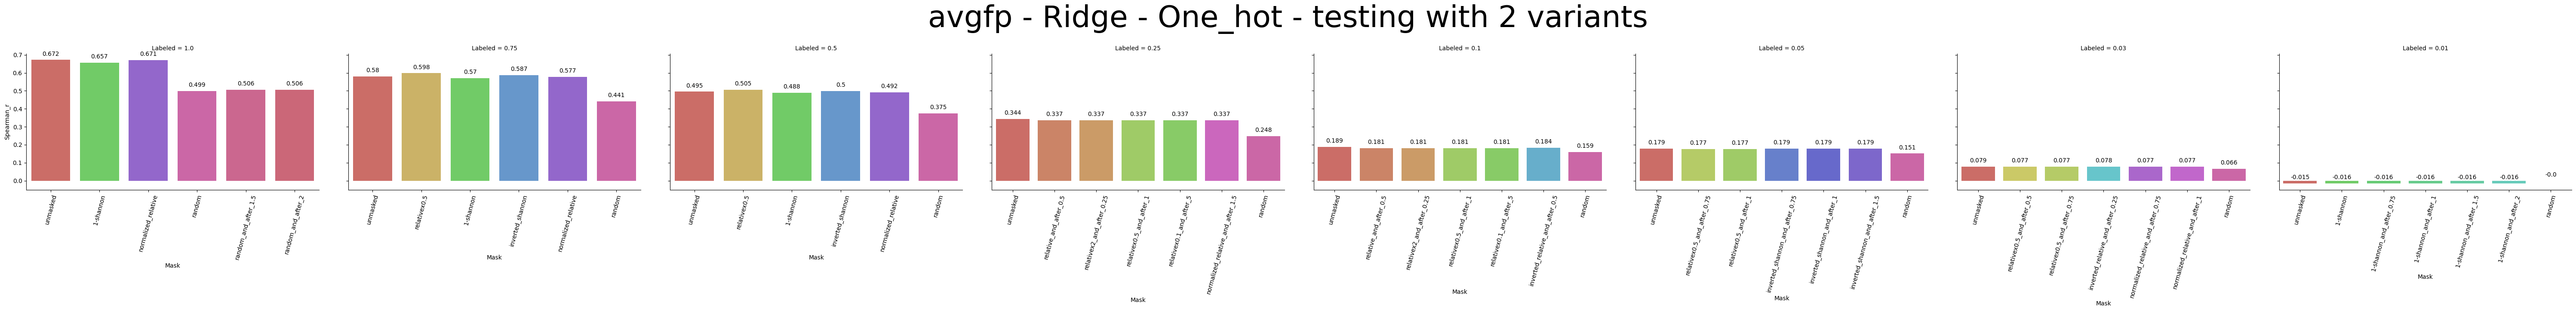

<Figure size 2500x500 with 0 Axes>

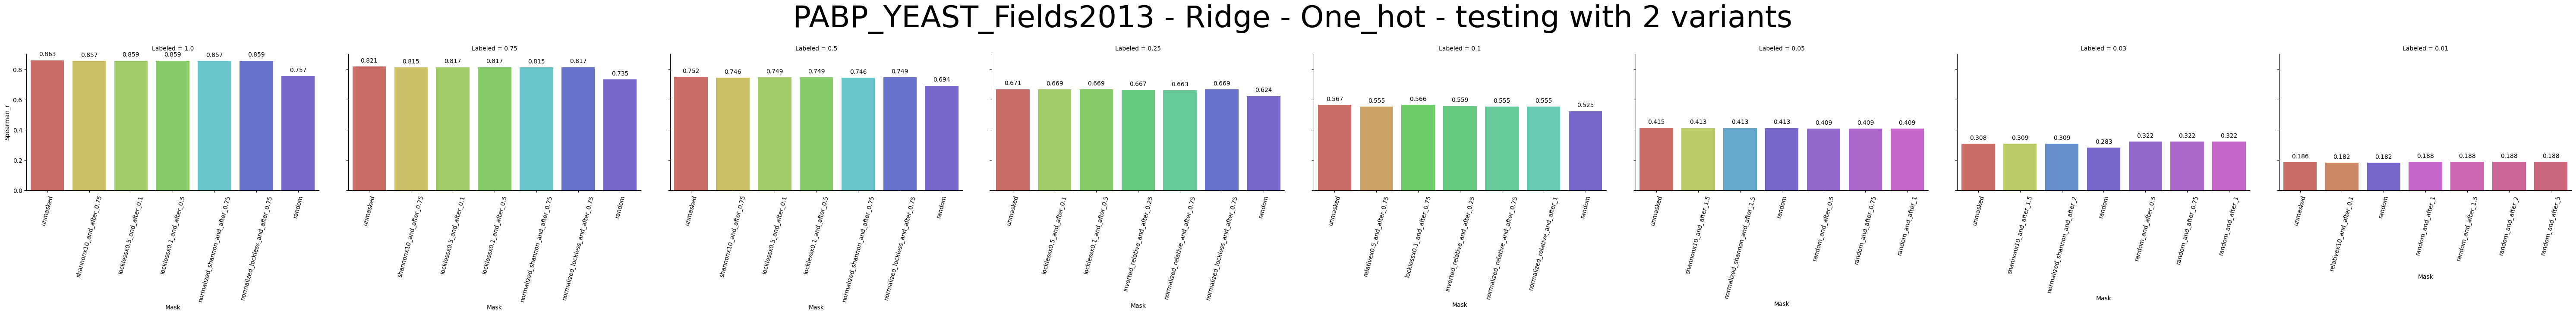

<Figure size 2500x500 with 0 Axes>

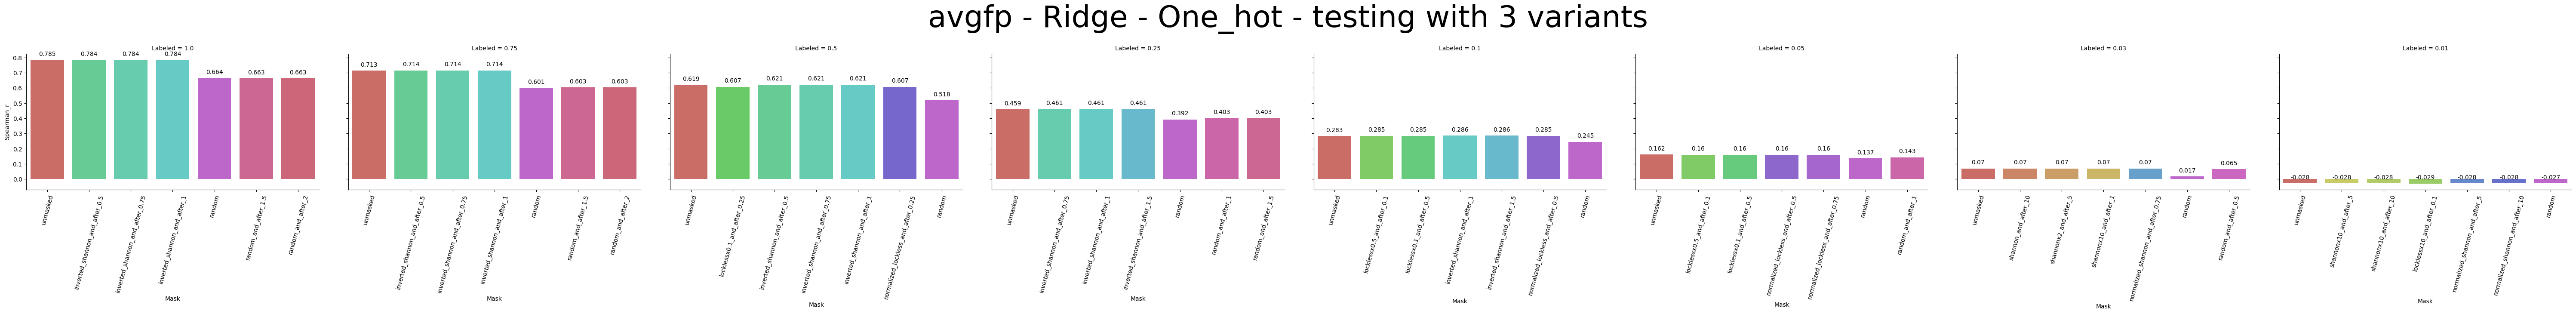

<Figure size 2500x500 with 0 Axes>

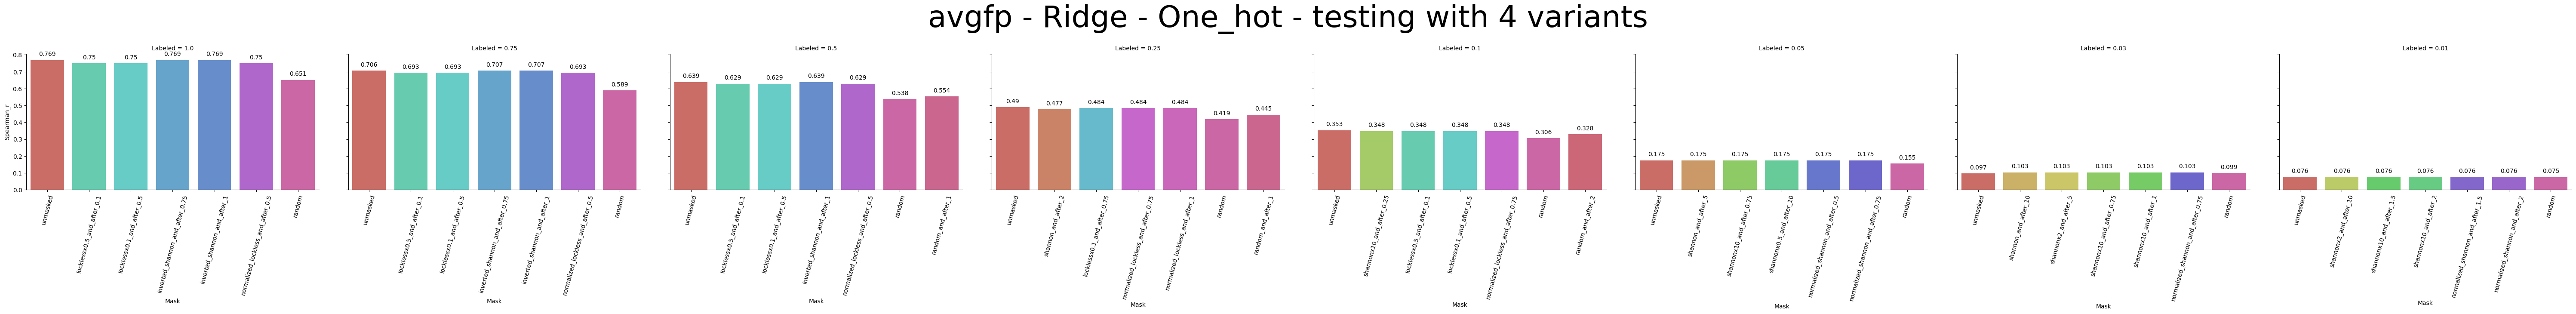

<Figure size 2500x500 with 0 Axes>

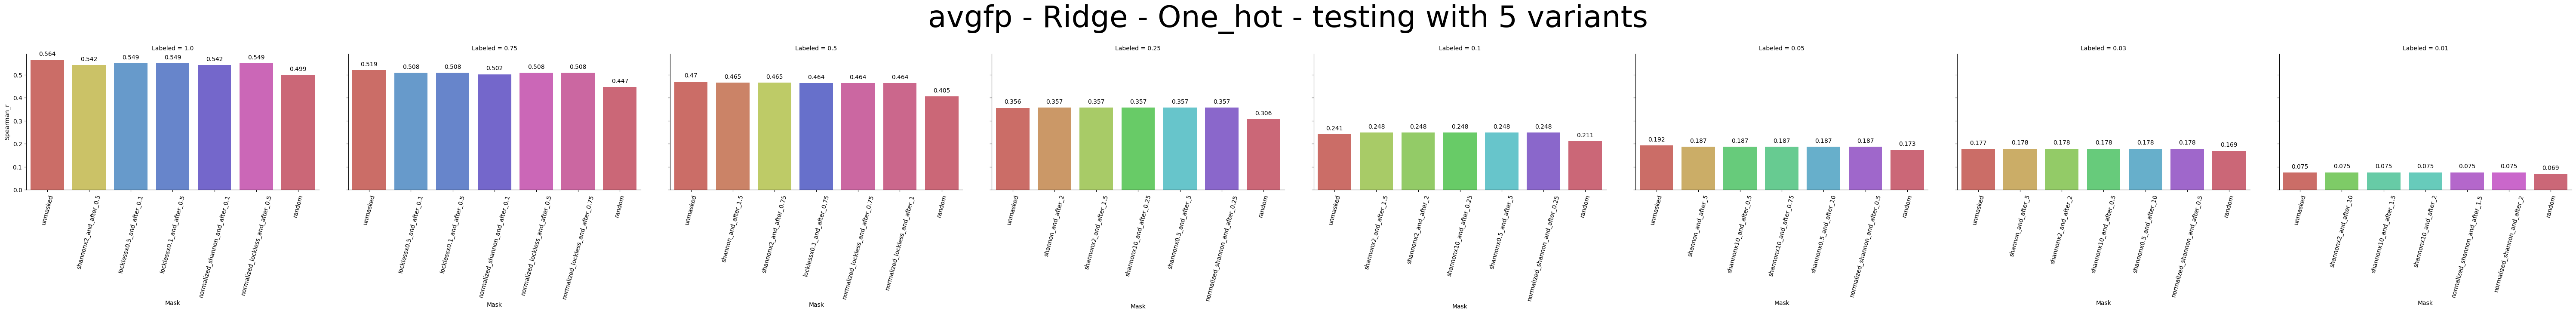

<Figure size 2500x500 with 0 Axes>

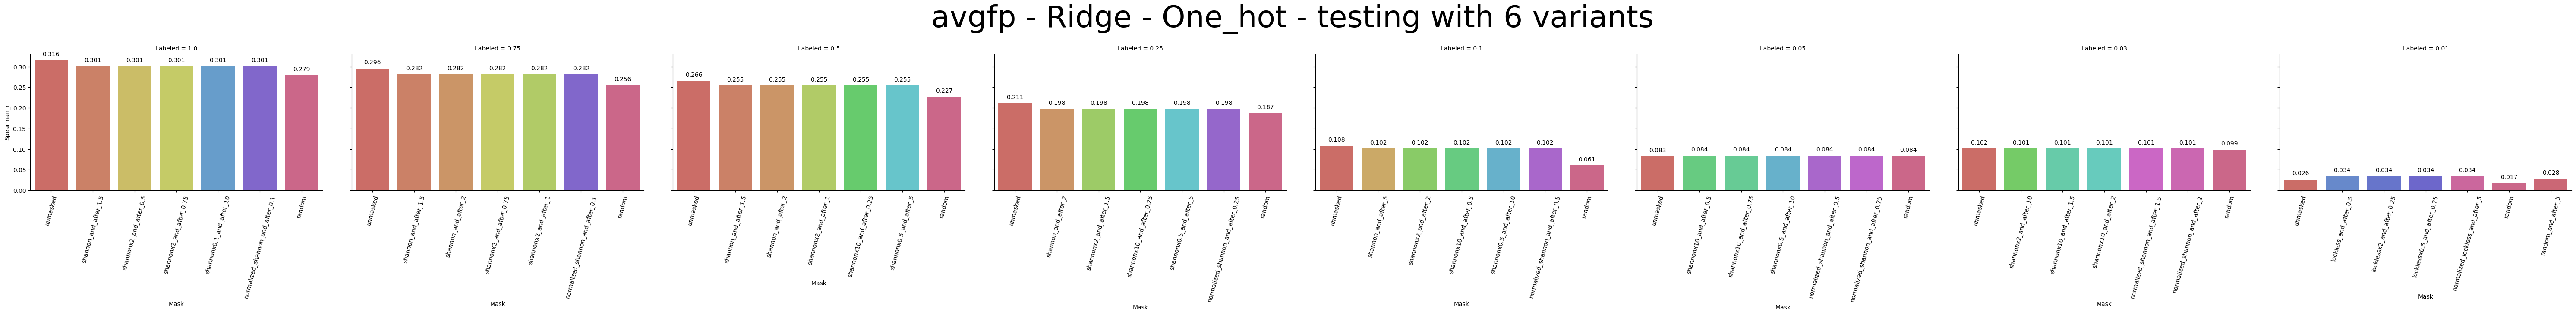

<Figure size 2500x500 with 0 Axes>

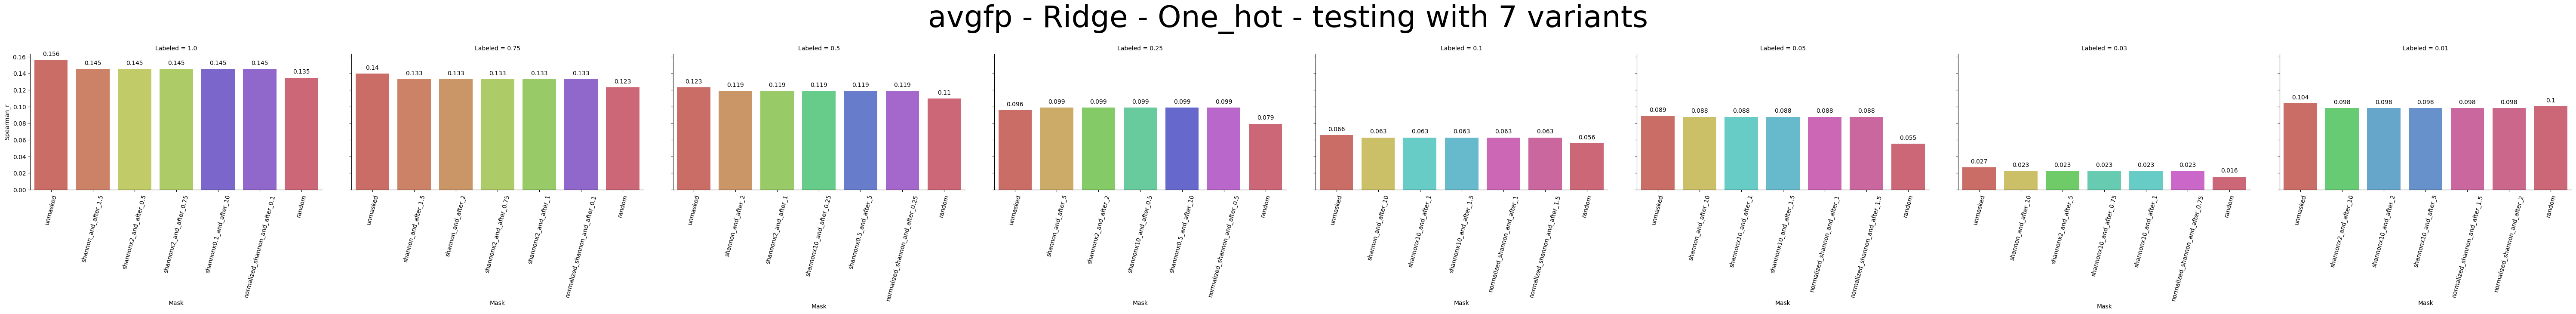

<Figure size 2500x500 with 0 Axes>

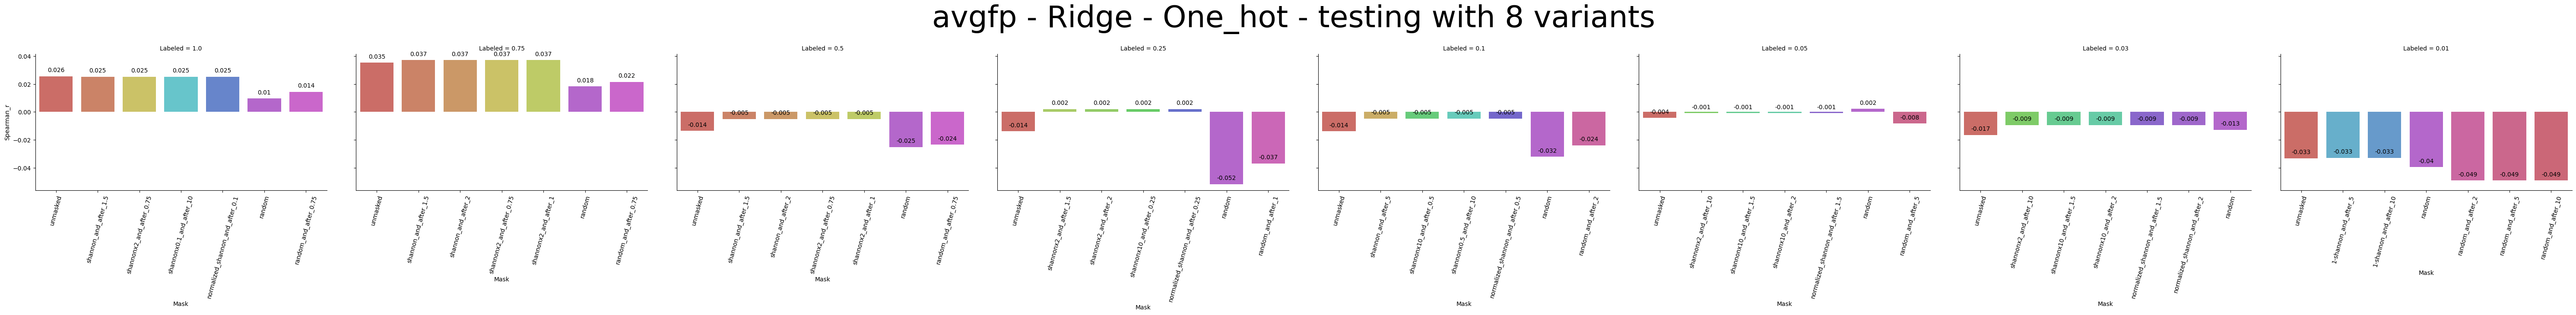

<Figure size 2500x500 with 0 Axes>

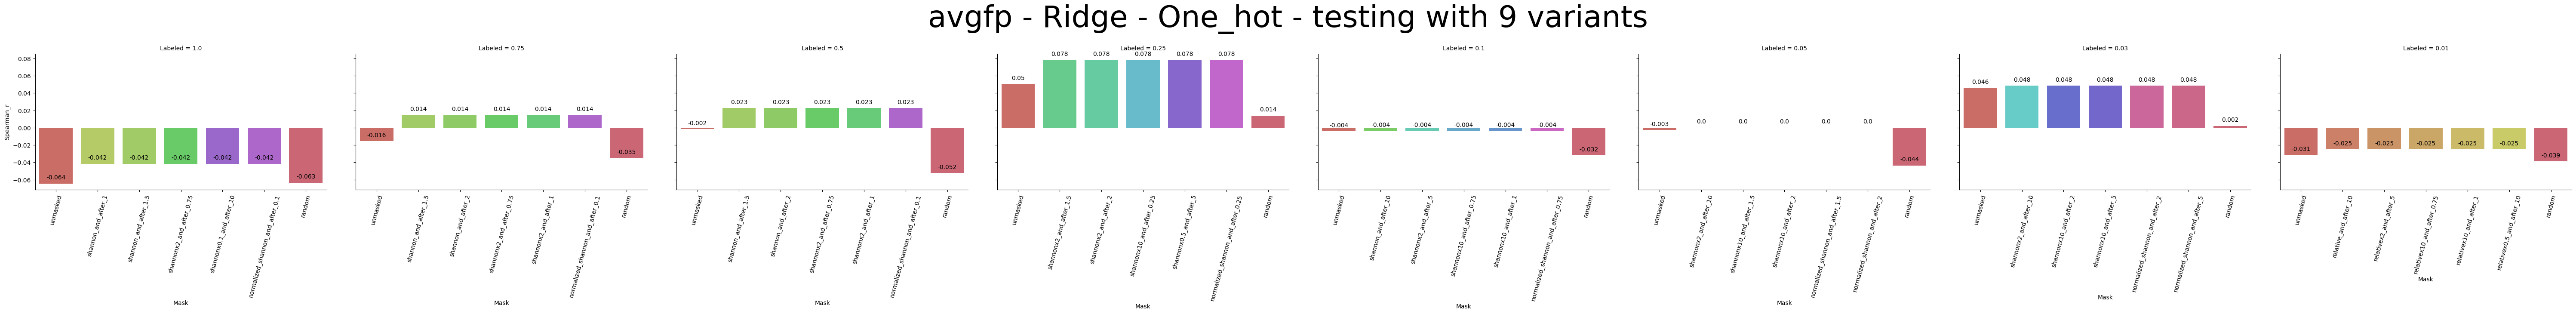

<Figure size 2500x500 with 0 Axes>

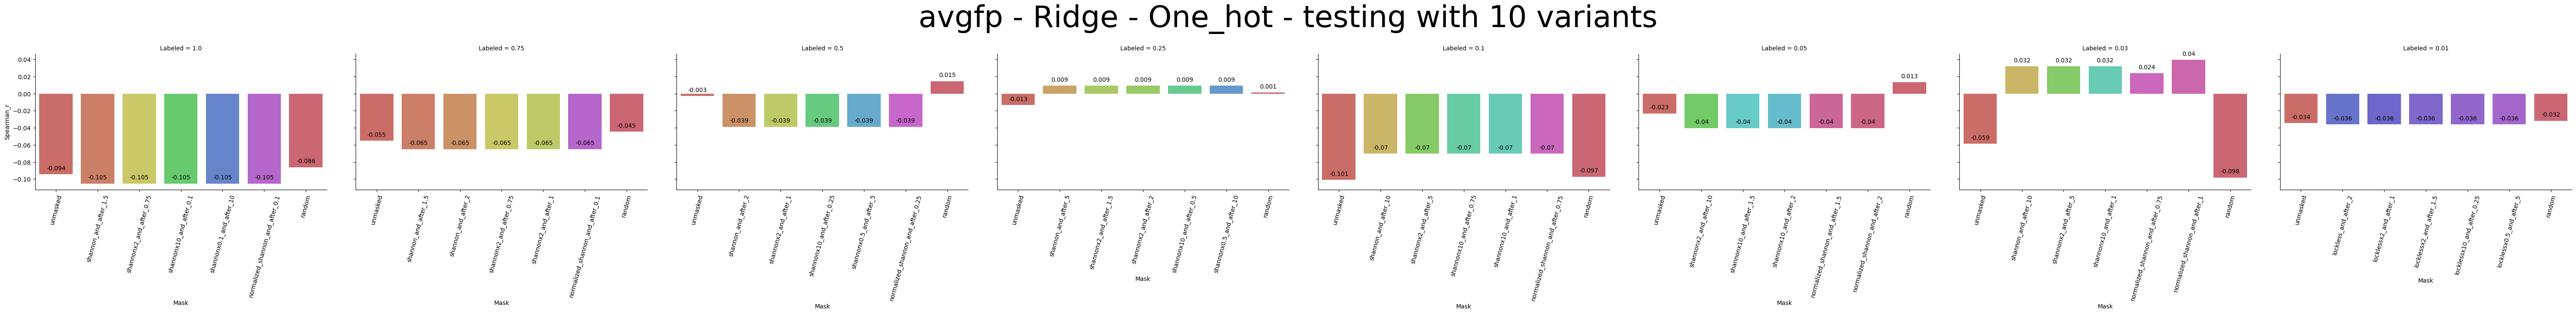

In [17]:
# Plot for every pair Dataset/Test N variants
for dataset, test_N_variants in df[['Dataset', 'Test N variants']].drop_duplicates().sort_values(by="Test N variants").values:
    # Now do the same buy in a single plot grouping the masks by labeled_size
    plt.figure(figsize=(25, 5))

    plt_df = df[(df["Encoding"] == encoding) & (df["Model"] == model) & (df["Dataset"] == dataset) & (df["Test N variants"] == test_N_variants)]

    # Remove the empty bars in the plot
    g = sns.catplot(kind='bar',
                data=plt_df,
                col='Labeled',
                x='Mask', 
                y=metric,
                hue='Mask', dodge=False, sharex=False,
                height=5, aspect=1.5, legend_out=False,
                col_order=sorted(df[df["Encoding"] == encoding]["Labeled"].unique(), reverse=True),
                palette=sns.color_palette("hls", len(plt_df["Mask"].unique())).copy()
                )
    # Show values on top of the bars
    for ax in g.axes.flat:
        for p in ax.patches:
            ax.annotate(str(round(p.get_height(), 3)), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    # Put the groups closer
    g.fig.subplots_adjust(wspace=0.1)
    # Title
    g.fig.suptitle(f'{dataset} - {model} - {encoding} - testing with {test_N_variants} variants', fontsize=50)
    # Some space below the title
    g.fig.subplots_adjust(top=0.75)

    # Tilt the x labels 75 degrees
    g.set_xticklabels(rotation=75)

    plt.show()

In [22]:
# Fixed parameters
encoding = "One_hot"
model = "StandardScaler_Ridge"
metric = "Spearman_r"
#metric = "RMSE"

<Figure size 2500x500 with 0 Axes>

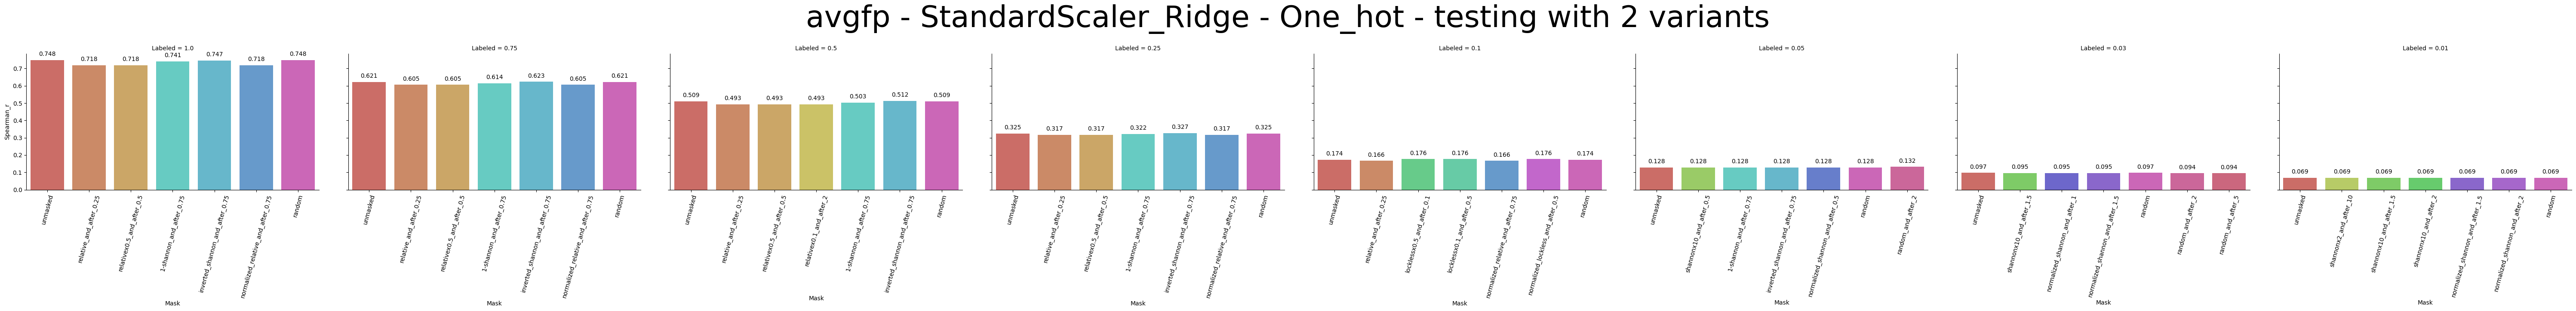

<Figure size 2500x500 with 0 Axes>

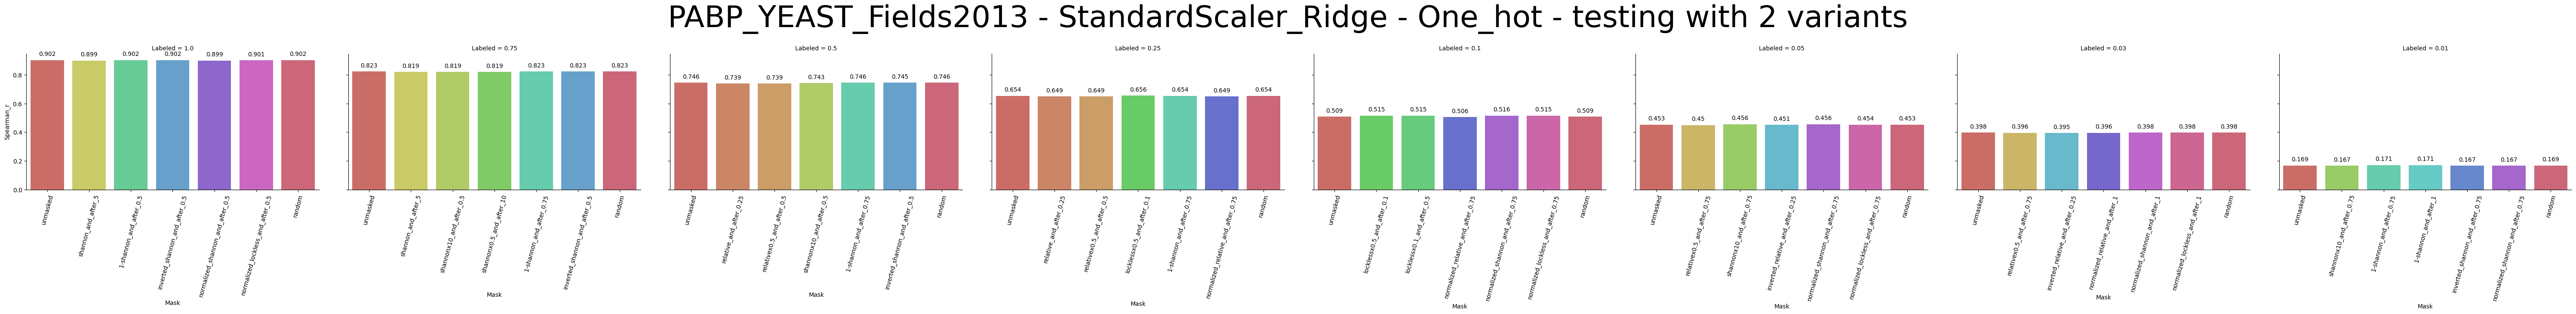

<Figure size 2500x500 with 0 Axes>

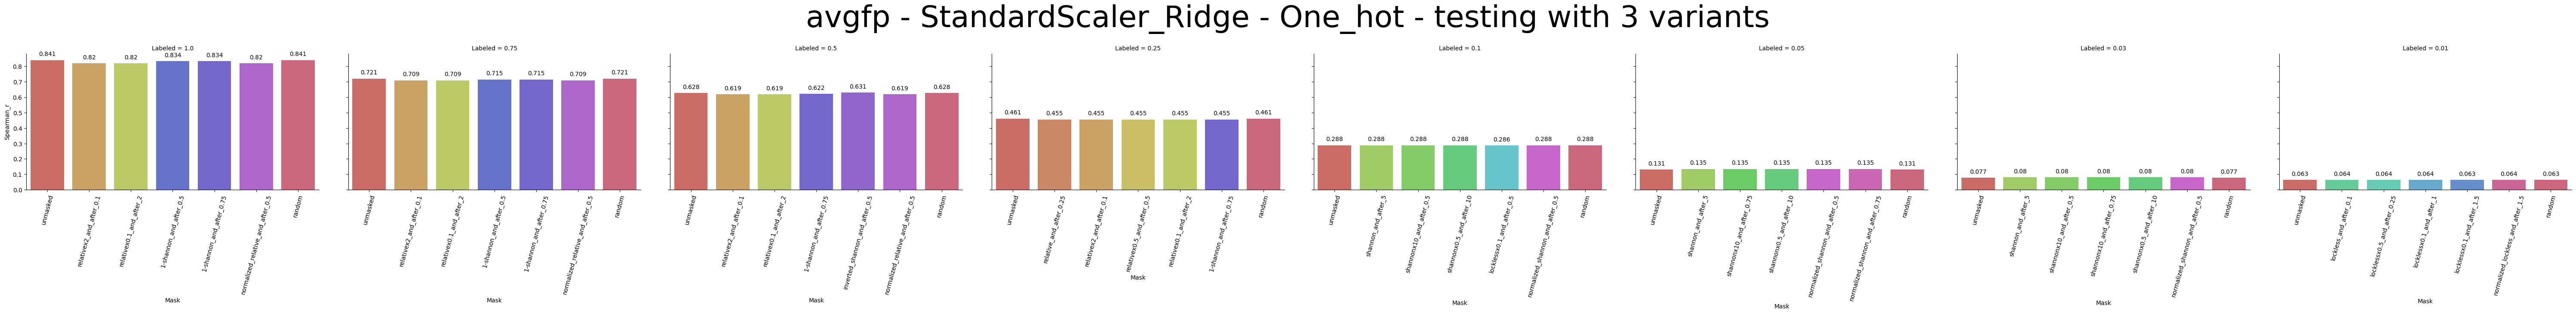

<Figure size 2500x500 with 0 Axes>

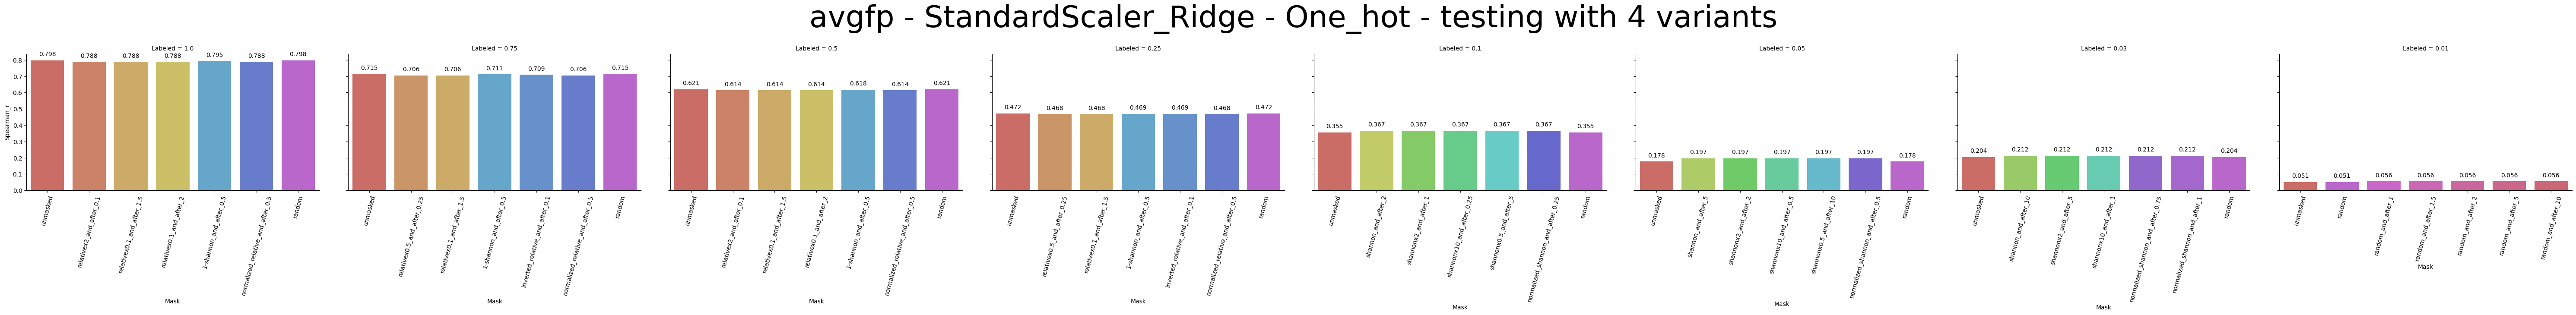

<Figure size 2500x500 with 0 Axes>

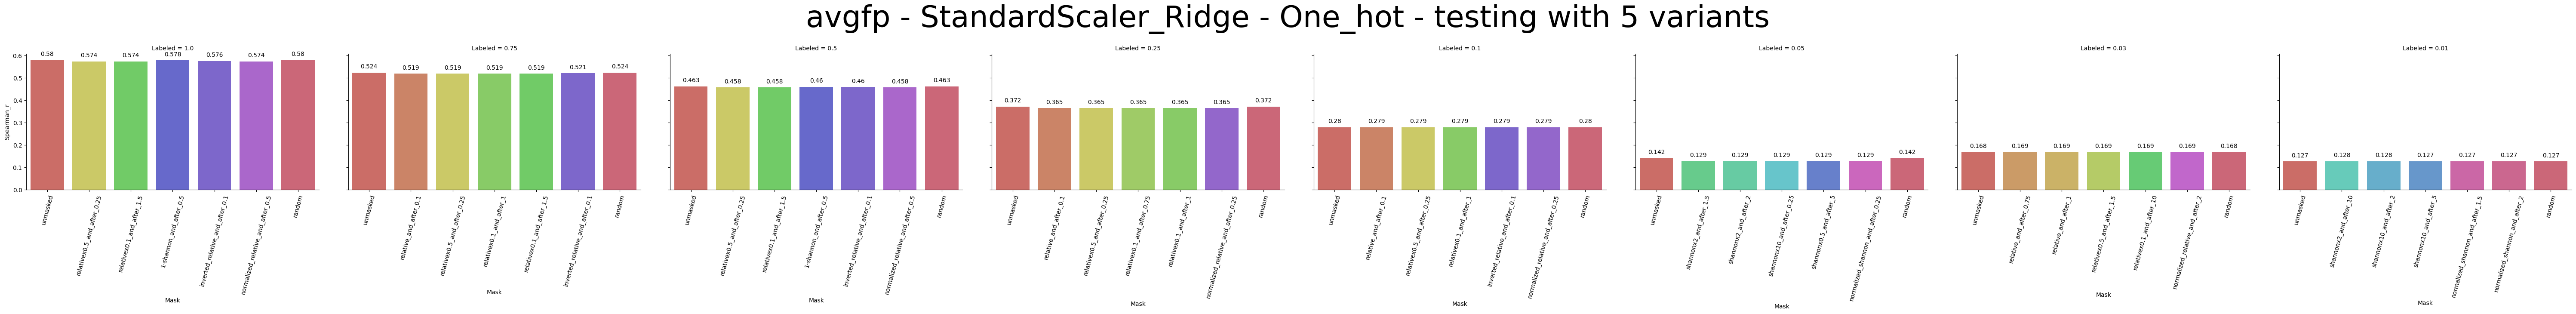

<Figure size 2500x500 with 0 Axes>

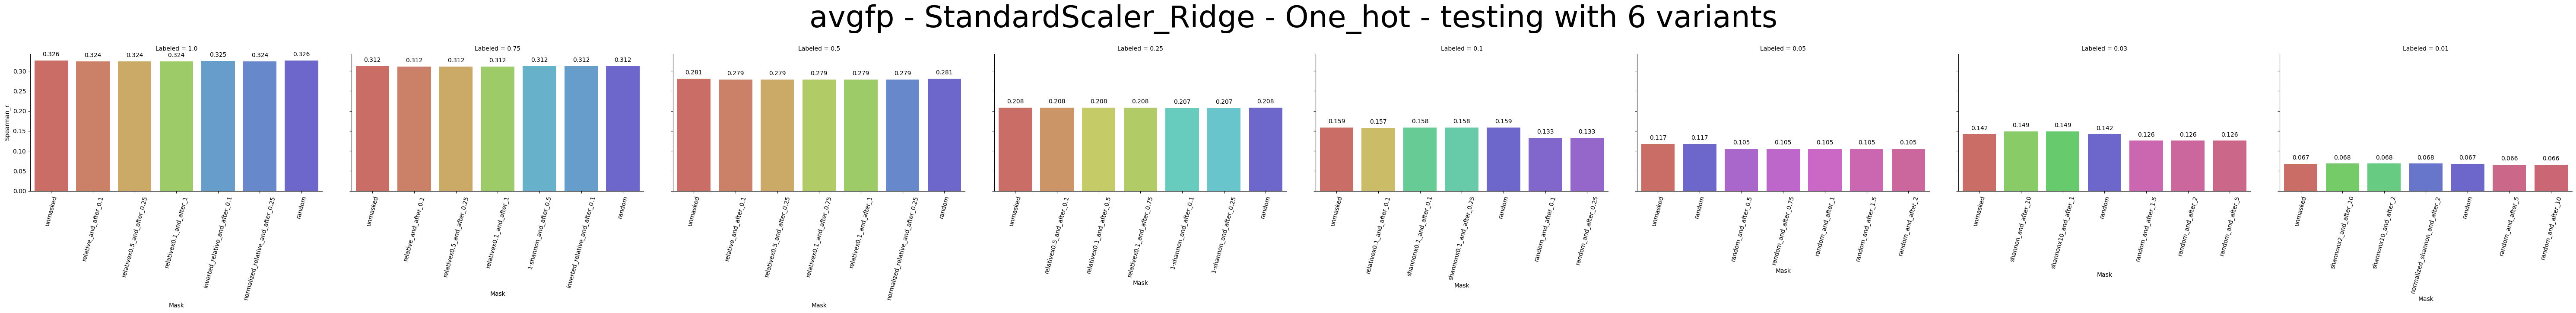

<Figure size 2500x500 with 0 Axes>

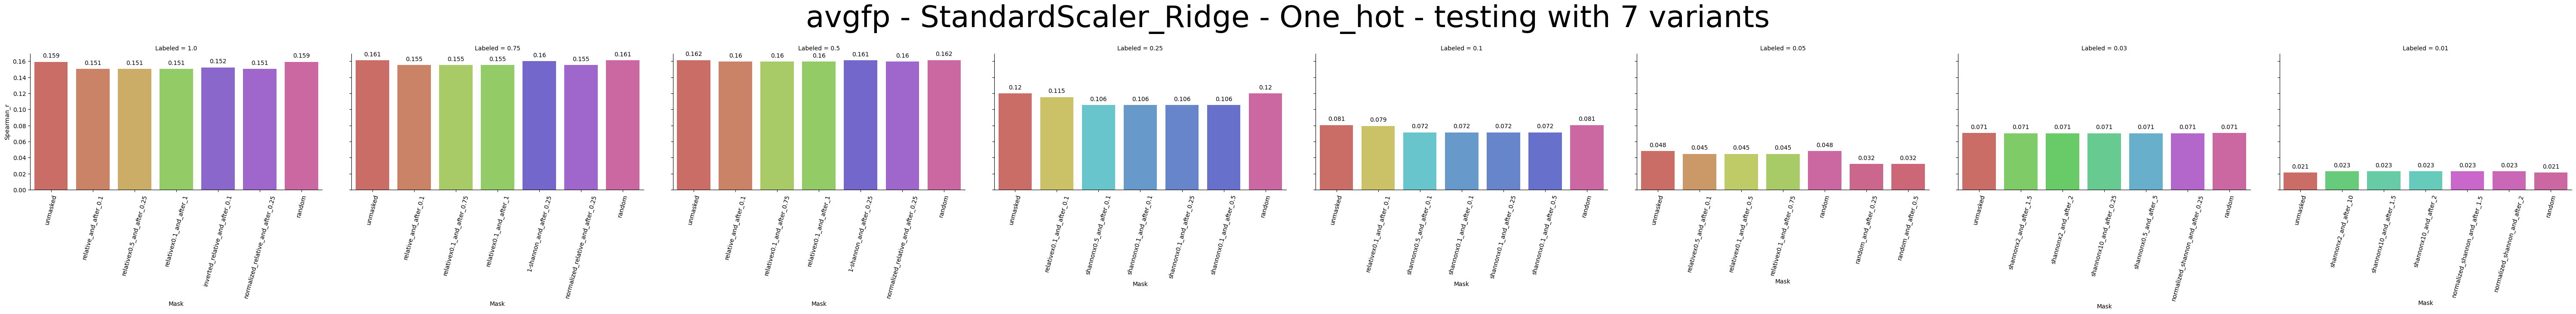

<Figure size 2500x500 with 0 Axes>

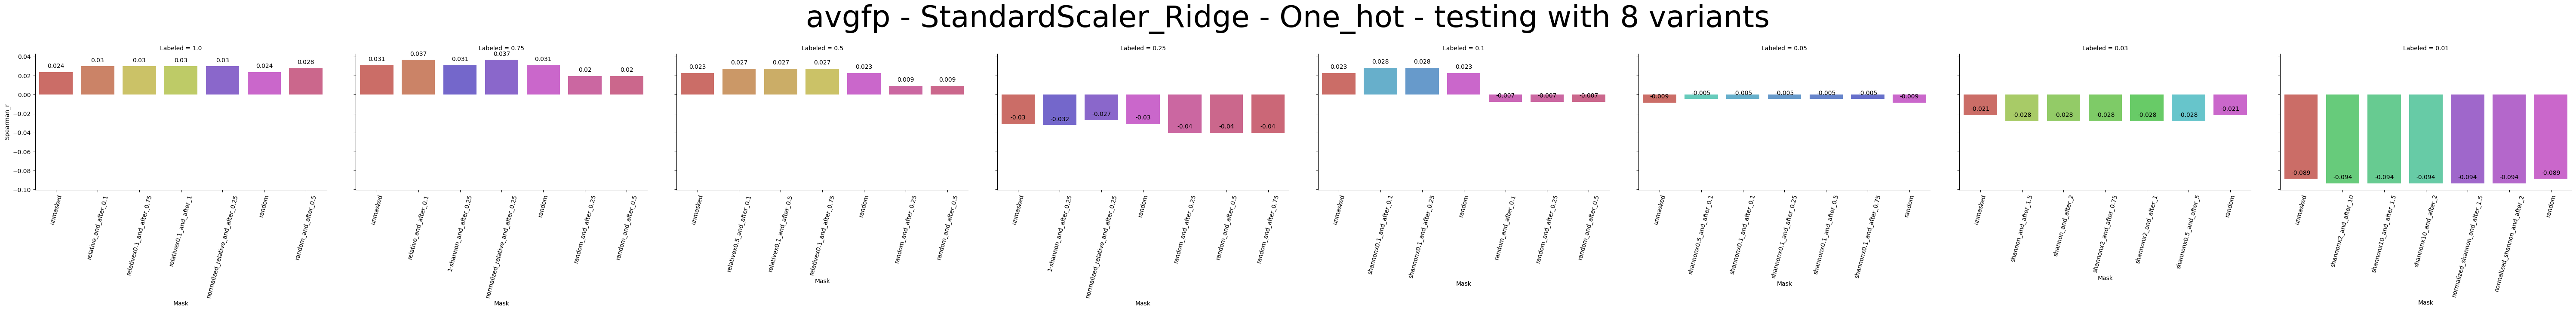

<Figure size 2500x500 with 0 Axes>

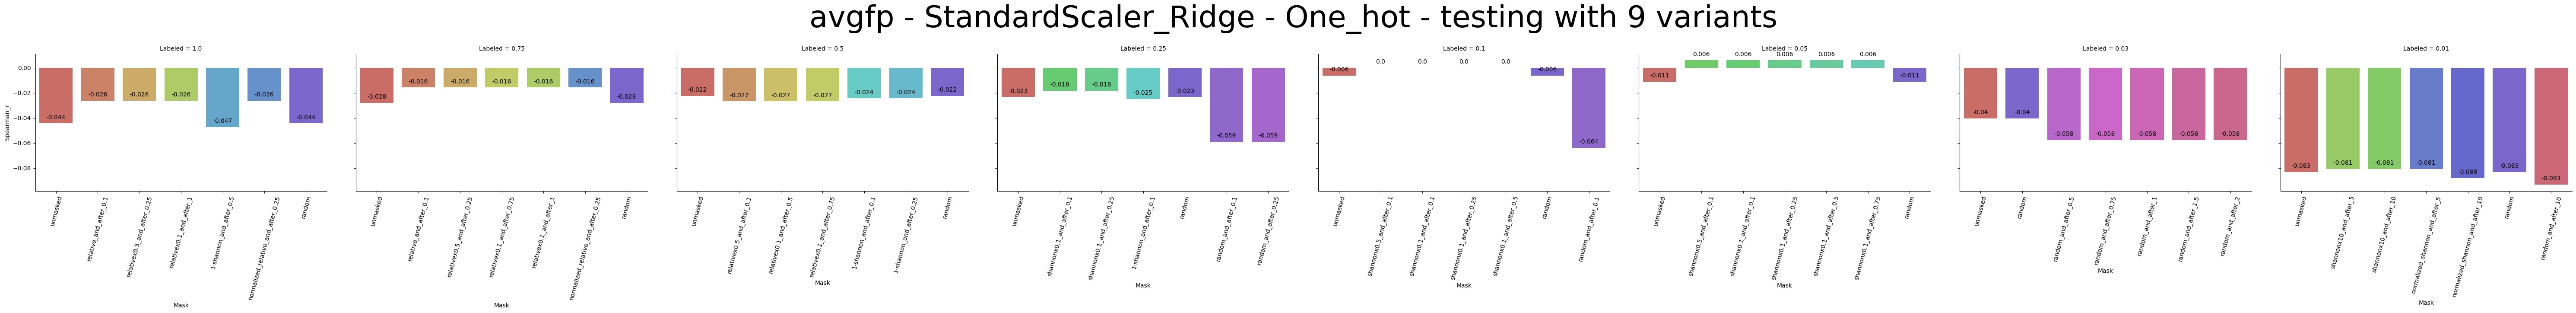

<Figure size 2500x500 with 0 Axes>

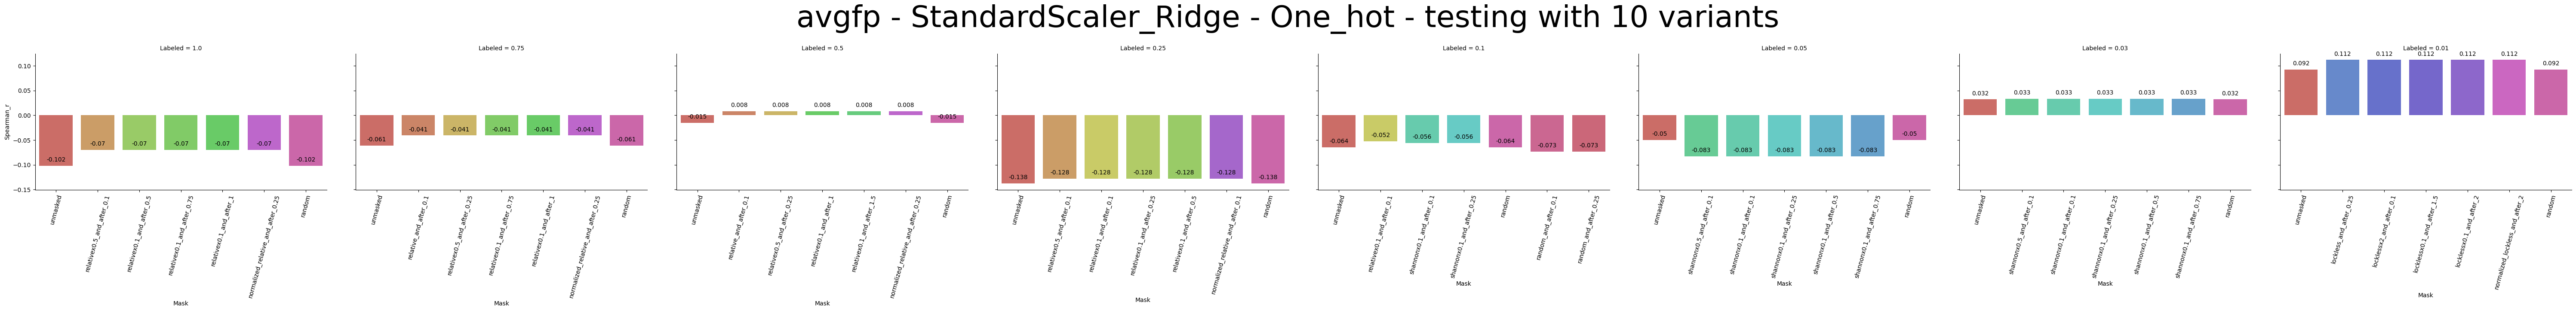

In [23]:
# Plot for every pair Dataset/Test N variants
for dataset, test_N_variants in df[['Dataset', 'Test N variants']].drop_duplicates().sort_values(by="Test N variants").values:
    # Now do the same buy in a single plot grouping the masks by labeled_size
    plt.figure(figsize=(25, 5))

    plt_df = df[(df["Encoding"] == encoding) & (df["Model"] == model) & (df["Dataset"] == dataset) & (df["Test N variants"] == test_N_variants)]
    # Remove the empty bars in the plot
    g = sns.catplot(kind='bar',
                data=plt_df,
                col='Labeled',
                x='Mask', 
                y=metric,
                hue='Mask', dodge=False, sharex=False,
                height=5, aspect=1.5, legend_out=False,
                col_order=sorted(df[df["Encoding"] == encoding]["Labeled"].unique(), reverse=True),
                palette=sns.color_palette("hls", len(plt_df["Mask"].unique())).copy()
                )
    # Show values on top of the bars
    for ax in g.axes.flat:
        for p in ax.patches:
            ax.annotate(str(round(p.get_height(), 3)), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    # Put the groups closer
    g.fig.subplots_adjust(wspace=0.1)
    # Title
    g.fig.suptitle(f'{dataset} - {model} - {encoding} - testing with {test_N_variants} variants', fontsize=50)
    # Some space below the title
    g.fig.subplots_adjust(top=0.75)

    # Tilt the x labels 75 degrees
    g.set_xticklabels(rotation=75)

    plt.show()

In [20]:
# Fixed parameters
encoding = "One_hot"
labeled_size = 1
test_N_variants = 2
#metric = "Spearman_r"
metric = "RMSE"

AttributeError: 'numpy.ndarray' object has no attribute 'bar'

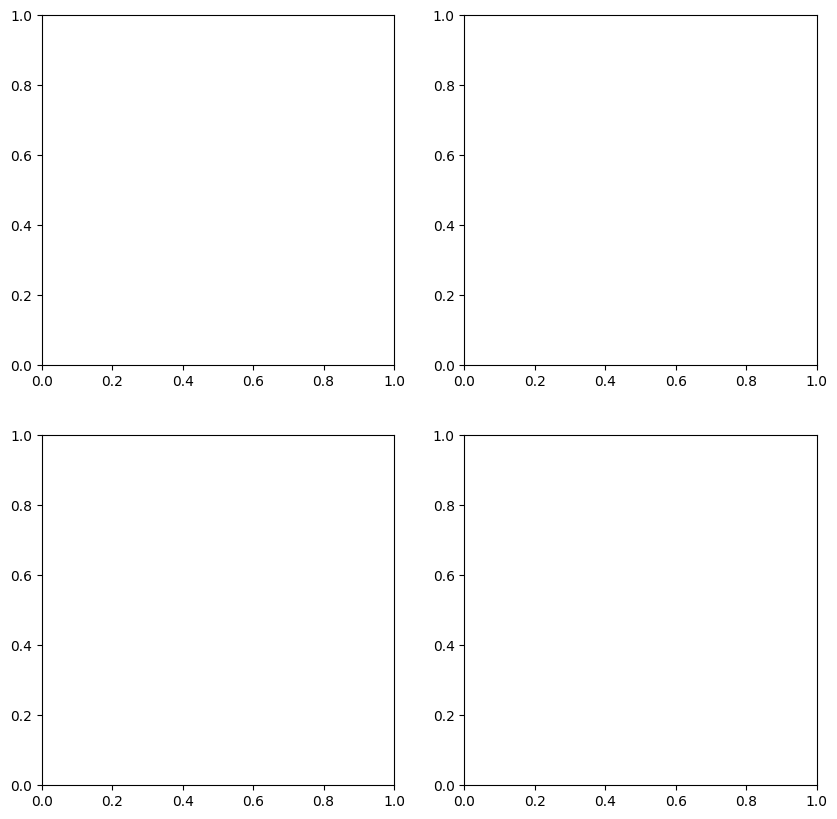

In [21]:
# Subplot catplot for every dataset/model pair
number_of_datasets = len(df[df["Encoding"] == encoding]["Dataset"].unique())
number_of_models = len(df[df["Encoding"] == encoding]["Model"].unique())
fig, axs = plt.subplots(number_of_models, number_of_datasets, figsize=(number_of_models*5, number_of_datasets*5))
for i, dataset in enumerate(sorted(df[df["Encoding"] == encoding]["Dataset"].unique())):
#    for j, model in enumerate(sorted(df[df["Encoding"] == encoding]["Model"].unique())):

    # Now do the same buy in a single plot grouping the masks by labeled_size
    plt_df = df[(df["Encoding"] == encoding) & (df["Model"] == model) & (df["Dataset"] == dataset) & (df["Labeled"] == labeled_size) & (df["Test N variants"] == test_N_variants)]

    # Remove the empty bars in the plot
    g = sns.barplot(data=plt_df,
                x='Mask', 
                y=metric,
                hue='Mask', dodge=False, 
                #ax=axs[i, j],
                ax=axs[i],
                palette=sns.color_palette("hls", len(plt_df["Mask"].unique())).copy()
                )
    # Show values at the top of the bars (inside them)
    for p in g.patches:
        g.annotate(str(round(p.get_height(), 3)), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, -10), textcoords='offset points', fontsize=8)
    # Title
    g.set_title(f'{dataset} - {model} - {encoding} - \ntesting with {test_N_variants} variants', fontsize=12)
    
    # Hide x labels
    g.set_xlabel("")
    
    # Tilt the x labels 75 degrees
    g.set_xticklabels(g.get_xticklabels(), rotation=75, ha="right", fontsize=8)
    # x labels sometimes are too long so we need to shorten them
    g.set_xticklabels([x.get_text()[:15] for x in g.get_xticklabels()])
    # Remove the legend
    g.get_legend().remove()
    # More space between the subplots
    fig.subplots_adjust(hspace=0.5, wspace=0.5)